In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!nvidia-smi

Thu Nov  9 07:35:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Load & Preprocessing Data 

In [17]:
(ds_train), ds_train_info = tfds.load(
    'stanford_dogs',
    split='train',
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

(ds_test), ds_test_info = tfds.load(
    'stanford_dogs',
    split='test',
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

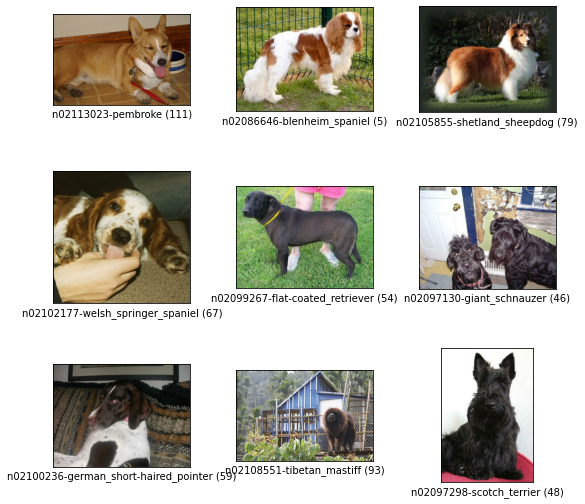

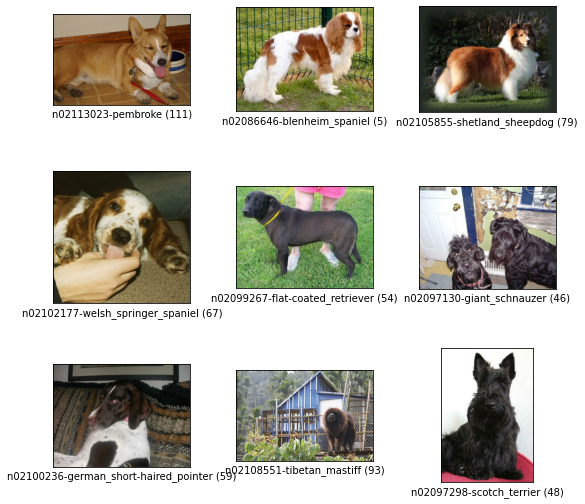

In [18]:
tfds.show_examples(ds_train, ds_train_info)

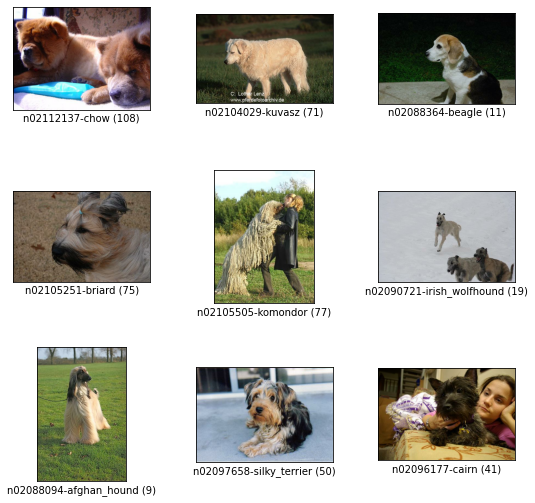

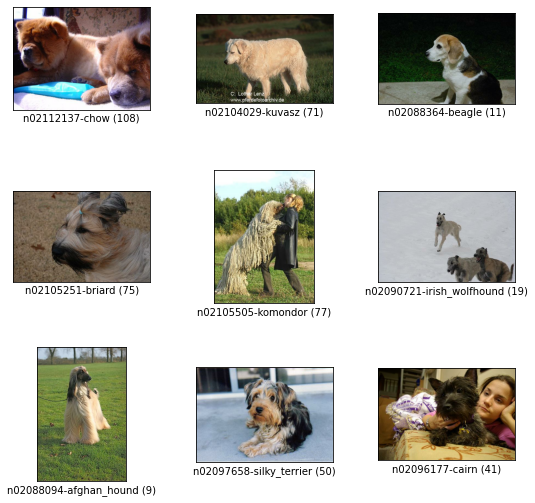

In [19]:
tfds.show_examples(ds_test, ds_test_info)

In [7]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

In [8]:
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [9]:
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [10]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [11]:
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [12]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [13]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 225., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [14]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, 
                               with_aug=False, 
                               with_cutmix=False,
                               with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    
    if not is_test:
        if with_cutmix:
            ds = ds.map(
                cutmix,
                num_parallel_calls=2
            )
        if with_mixup:
            ds = ds.map(
                mixup,
                num_parallel_calls=2
            )
        ds = ds.repeat()
        ds = ds.shuffle(200)
    else:
        if with_cutmix or with_mixup:
            ds = ds.map(
                onehot,
                num_parallel_calls=2
            )
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [20]:
ds_train_no_aug_no_cutmix_no_mixup = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug_no_cutmix_no_mixup = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_no_aug_cutmix_no_mixup = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=True)
ds_train_no_aug_no_cutmix_mixup = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=False, with_mixup=True)

In [22]:
num_classes = ds_train_info.features["label"].num_classes
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [23]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [24]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [25]:
from keras.callbacks import ModelCheckpoint
import json

EPOCH = 20

model_checkpoint = ModelCheckpoint(
    filepath="model/resnet50_epoch20_no_aug_no_cutmix_no_mixup.keras",
    save_best_only=True,
    monitor="val_loss"
)

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [26]:
resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________


In [27]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug_no_cutmix_no_mixup,
    callbacks=model_checkpoint,
    steps_per_epoch=int(ds_train_info.splits['train'].num_examples/16),
    validation_steps=int(ds_test_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


history_resnet50_no_aug_dict = history_resnet50_no_aug.history
json.dump(history_resnet50_no_aug_dict, open("model/history_resnet50_no_aug_dict", 'w'))

Epoch 1/20
750/750 [==============================] - 163s 202ms/step - loss: 2.2153 - accuracy: 0.4494 - val_loss: 3.1790 - val_accuracy: 0.2457


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
750/750 [==============================] - 150s 200ms/step - loss: 0.7701 - accuracy: 0.7821 - val_loss: 1.1301 - val_accuracy: 0.6725
Epoch 3/20
750/750 [==============================] - 150s 200ms/step - loss: 0.2404 - accuracy: 0.9501 - val_loss: 0.9876 - val_accuracy: 0.7128
Epoch 4/20
750/750 [==============================] - 150s 200ms/step - loss: 0.0653 - accuracy: 0.9942 - val_loss: 0.9198 - val_accuracy: 0.7334
Epoch 5/20
750/750 [==============================] - 150s 199ms/step - loss: 0.0288 - accuracy: 0.9989 - val_loss: 0.9311 - val_accuracy: 0.7329
Epoch 6/20
750/750 [==============================] - 150s 200ms/step - loss: 0.0181 - accuracy: 0.9994 - val_loss: 0.9347 - val_accuracy: 0.7386
Epoch 7/20
750/750 [==============================] - 150s 199ms/step - loss: 0.0133 - accuracy: 0.9997 - val_loss: 0.9471 - val_accuracy: 0.7380
Epoch 8/20
750/750 [==============================] - 150s 200ms/step - loss: 0.0097 - accuracy: 0.9998 - val_loss: 0.9619 -

In [23]:
from keras.callbacks import ModelCheckpoint
import json

EPOCH = 20

resnet50_with_cutmix= keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

model_checkpoint = ModelCheckpoint(
    filepath="model/resnet50_epoch20_no_aug_yes_cutmix_no_mixup.keras",
    save_best_only=True,
    monitor="val_loss"
)

resnet50_with_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [24]:
history_resnet50_no_aug = resnet50_with_cutmix.fit(
    ds_train_no_aug_cutmix_no_mixup, 
    callbacks=model_checkpoint,
    steps_per_epoch=int(ds_train_info.splits['train'].num_examples/16),
    validation_steps=int(ds_test_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
363/750 [=============>................] - ETA: 1:05 - loss: 4.2535 - accuracy: 0.1188

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  slice index 9 of dimension 0 out of bounds.
	 [[{{node strided_slice_82}}]]
	 [[IteratorGetNext]]
  (1) Invalid argument:  slice index 9 of dimension 0 out of bounds.
	 [[{{node strided_slice_82}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_22725]

Function call stack:
train_function -> train_function


# 회고

1. Project 병렬적으로 돌리도록 스크립트를 짜자. (LMS, Colab, local 환경에서 돌려 결과만 합치자)  
2. data의 shape을 항상 세심하게 체크하자 (예를 들어 sparse categorical_crossentropy와 categorical_crossentropy 차이를 구별 & Batch size에 결정 되는 steps_per_epoch을 고려하자